In [56]:
# Imports
%matplotlib inline
import quandl
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from datetime import datetime, timedelta
from collections import defaultdict
import matplotlib.pyplot as plt

In [355]:
PERIODS = 12
DAYS_BETWEEN = 30

In [347]:
# Get price data from Quandl
bitcoin = quandl.get("BCHAIN/MKPRU")
bitcoin = bitcoin.loc['2011-01-01':] # Remove the 0's
bitcoin.dropna(inplace=True)
bitcoin.columns = ['Last']

In [349]:
def buy_all_now_return(d):
    '''d is the date that you are buying'''
    price_today = bitcoin.loc[d,'Last']
    ret = bitcoin['Last'].iloc[-1] / price_today - 1
    return ret

In [351]:
buy_all_now_return('2017-01-01')

4.228310430922937

In [348]:
def dollar_cost_average_return(d, periods=PERIODS, freq= str(DAYS_BETWEEN) + 'D'):
    '''spread your purchase over the next period months from date d'''
    buy_dates = pd.date_range(start=d, periods=periods, freq=freq)
    buy_dates = [i for i in buy_dates if i < bitcoin.index[-1]] # remove dates in the future
    if len(buy_dates) < 2:
        print "Error %s" % str(d)
    return np.mean([buy_all_now_return(d) for d in buy_dates])

In [350]:
dollar_cost_average_return('2017-01-01')

1.7452396431413406

In [364]:
color = []
diffs = []

end_date = (bitcoin.index[-1] - timedelta(days=PERIODS * DAYS_BETWEEN))#.strftime('%Y-%m-%d') 
#end_date = (datetime.now() - timedelta(days=1 * DAYS_BETWEEN + 1))#.strftime('%Y-%m-%d') 
#data = bitcoin.loc[:end_date].copy()

for d, row in bitcoin.iterrows():
    if d < end_date:
        bn = buy_all_now_return(d)
        dca = dollar_cost_average_return(d)
        
        years = (bitcoin.index[-1] - d).days / 365.25
        dca_pa = (dca + 1) ** (1/years) - 1
        bn_pa = (bn + 1) ** (1/years) - 1
        diffs.append( (dca_pa-bn_pa)*100 )
        
        if dca>bn:
            color.append('green')
        else:
            color.append('red')
    else:
        diffs.append(np.NAN)
        color.append('gray')

bitcoin['color'] = color
bitcoin['diffs'] = diffs

In [365]:
bitcoin.index[-1] - end_date

Timedelta('360 days 00:00:00')

In [366]:
bitcoin['color'].value_counts()

red      1936
green     719
gray      361
Name: color, dtype: int64

In [367]:
days_dca_better = float(bitcoin['color'].value_counts()[1]) / (len(bitcoin) - PERIODS * DAYS_BETWEEN) * 100
print "Dollar cost averaging is better %0.2f%% of the time" % days_dca_better

Dollar cost averaging is better 27.07% of the time


In [369]:
bitcoin['red'] = np.where(bitcoin['color'] == 'red', bitcoin['Last'], np.NAN)
bitcoin['gray'] = np.where(bitcoin['color'] == 'gray', bitcoin['Last'], np.NAN)

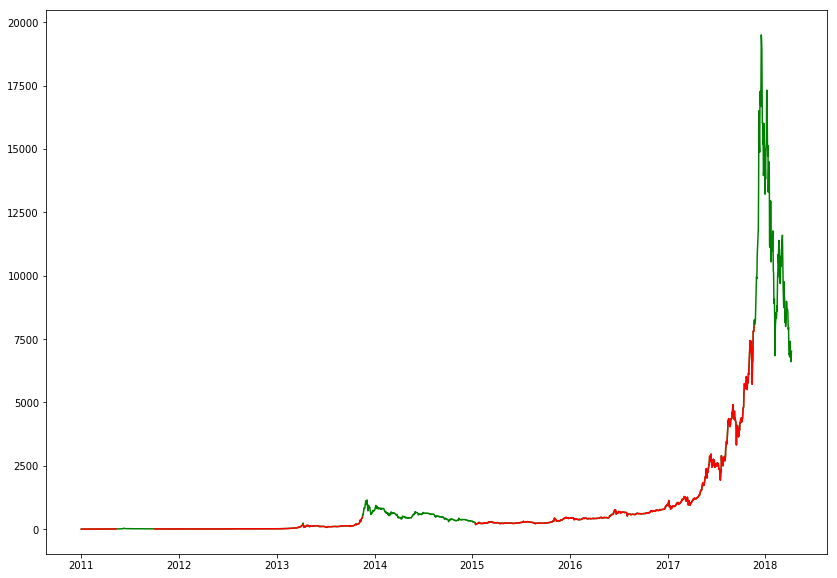

In [401]:
plt.figure(figsize=(14,10))
subset = bitcoin.loc[:end_date]

plt.plot(subset['Last'].loc[:end_date], color='green')
plt.plot(subset['red'], color='red');
plt.plot(subset['gray'],color='gray', linestyle='dashed', alpha=0.2);

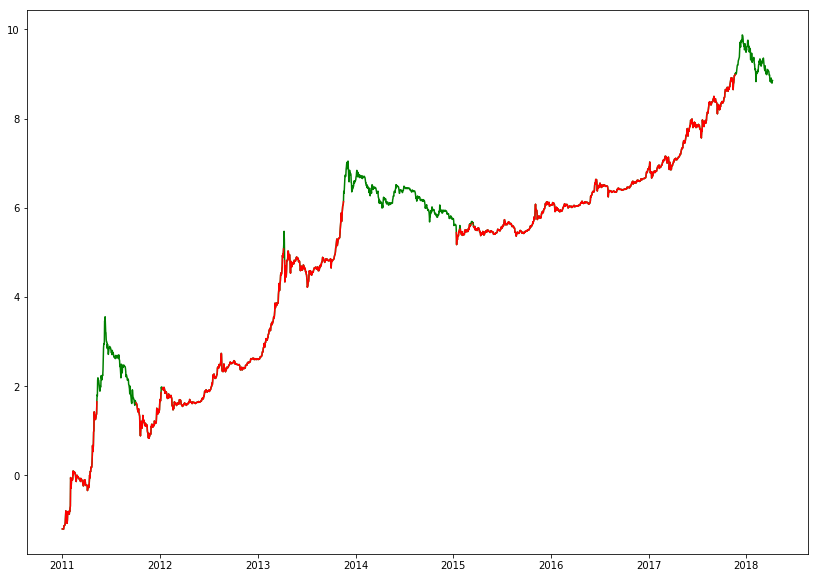

In [400]:
plt.figure(figsize=(14,10))
subset = bitcoin.loc[:end_date]

plt.plot(np.log(subset['Last'].loc[:end_date]), color='green')
plt.plot(np.log(subset['red']), color='red');
plt.plot(np.log(subset['gray']),color='gray', linestyle='dashed', alpha=0.2);

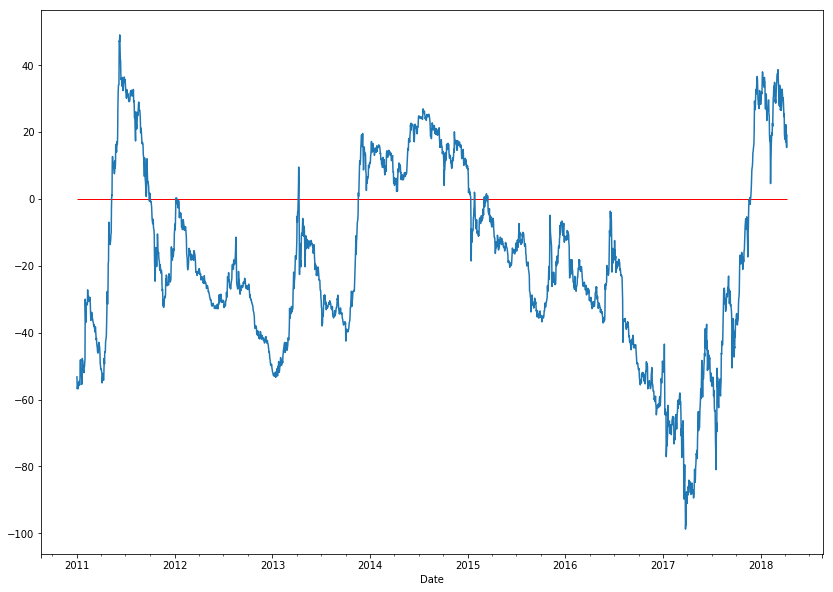

In [388]:
t = bitcoin['diffs'].loc[:end_date]
t.plot(figsize=(14,10));
plt.hlines(0, t.index[0], t.index[-1], color='red', linewidth=1);
#plt.hlines(t[t>0].mean(), t.index[0], t.index[-1], color='green', linewidth=1, linestyle='dashed');
#plt.hlines(t[t<0].mean(), t.index[0], t.index[-1], color='red', linewidth=1, linestyle='dashed');

In [386]:
print t[t>0].mean()
print t[t<0].mean()

18.0083583593
-31.913830735


In [395]:
from bokeh.plotting import figure, output_file, show

output_file("dollar_cost_averaging.html")

p = figure(plot_width=1000, plot_height=600, x_axis_type="datetime")

p.line(subset['Last'].index, subset['Last'], color="green", alpha=0.5, line_width=2)
p.line(subset['red'].index, subset['red'], color="red", alpha=0.5, line_width=2)
p.line(subset['gray'].index, subset['gray'], color="gray", alpha=1, line_width=2)

show(p)